# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toytree
import toyplot
import scipy.stats as sc

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from adascape.base import IR12SpeciationModel, DD03SpeciationModel
from adascape.fastscape_ext import FastscapeElevationTrait

## Functions to compute and visualize speciation model

In [2]:
def run_model(trait_comp=False, num_gen=500, pop_size = 10, dt=1,
             sigma_env_trait=0.3, mut_prob=1.0, sigma_mut=0.05, sigma_mov=5,
             random_seed=1234, taxon_threshold=0.05, distance_metric='centroid',
              taxon_def='spec_clus',always_direct_parent=True):
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    environment = X + r.rand(*Y.shape)
    trait_01_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
    trait_01_elev.initialize()
    init_trait_funcs =  {
    'trait_1': trait_01_elev.init_trait_func,
    }
    opt_trait_funcs = {
    'trait_1': trait_01_elev.opt_trait_func
    }
    
    if trait_comp:
        model = DD03SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size,
                                    car_cap_max=250, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, sigma_comp_trait=sigma_env_trait, 
                                    sigma_comp_dist=sigma_env_trait, random_seed=random_seed, 
                                    distance_metric=distance_metric, taxon_threshold=taxon_threshold, 
                                    taxon_def=taxon_def, always_direct_parent=always_direct_parent)
    else:
        model = IR12SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size, 
                                    nb_radius=50, car_cap=25, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, random_seed=random_seed, 
                                    taxon_threshold=taxon_threshold, distance_metric=distance_metric, 
                                    taxon_def=taxon_def, always_direct_parent=always_direct_parent)

    model.initialize()
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(dt)
        dfs.append(model.to_dataframe())
        model.update_individuals(dt)
    return pd.concat(dfs).reset_index(drop=True), environment, X

In [3]:
def plot_sol(dtf, elevation, X):
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

In [4]:
def toytree_plot(tree, ind_dtf):
    """
    Plot of phylogenetic tree using library toytree and following the cookbook example 
    https://toytree.readthedocs.io/en/latest/
    
    Parameters
    ----------
    tree : class 'dendropy.tree'
        Phylogenetic tree as class dendropy.tree
    ind_dtf : class 'pandas.DataFrame'
        Speciation model output with data for all individuals
        
    """
    ttree = toytree.tree(tree.as_string(schema='newick'))
    # generate a distribution between 0 and 1 for each tip in the tree
    points = np.linspace(0, 1, 50)
    dists = {}
    for tip in ttree.get_tip_labels():
        trait_values = ind_dtf[ind_dtf.taxon_id==int(tip)].trait_0.values
        if trait_values.size > 1:
            kernel = sc.gaussian_kde(trait_values)                                 
            dists[tip] = kernel(points)
        else:
            dists[tip] = None
    # set up canvas for two panel plot
    canvas = toyplot.Canvas(width=300, height=400)

    # add tree to canvas
    ax0 = canvas.cartesian(bounds=(50, 180, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)
    ttree.draw(axes=ax0, tip_labels=False)
    ax0.show = False

    # add histograms to canvas
    ax1 = canvas.cartesian(bounds=(200, 275, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)

    # iterate from top to bottom (ntips to 0)
    for tip in range(ttree.ntips)[::-1]:

        # select a color for hist
        color = toytree.colors[int((tip) / 100)]

        # get tip name and get hist from dict
        tipname = ttree.get_tip_labels()[tip]
        probs = dists[tipname]
        
        if probs is not None:
            
            # fill histogram with slightly overlapping histograms
            ax1.fill(
                points, probs / probs.max() * 1.25,
                baseline=[tip] * len(points),
                style={"fill": color, "stroke": "white", "stroke-width": 0.5},
                title=tipname,
            )
            # add horizontal line at base
            ax1.hlines(tip, opacity=0.5, color="grey", style={"stroke-width": 0.5})

    # hide y axis, show x
    ax1.y.show = False
    ax1.x.label.text = "Trait value"
    ax1.x.ticks.show = True

## Phylogeny for the speciation model without trait-mediated competition

In [5]:
ind_dtf1, elevation1, X1 = run_model(trait_comp=False)

/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [6]:
ind_dtf1

step   time   dt           x           y  taxon_id  ancestor_id  \
0          0    0.0  0.0  244.174942  110.251531       1.0          0.0   
1          0    0.0  0.0   95.048934  152.467702       1.0          0.0   
2          0    0.0  0.0  230.811558  215.905324       1.0          0.0   
3          0    0.0  0.0   65.423106  215.939418       1.0          0.0   
4          0    0.0  0.0   79.774265  168.720328       1.0          0.0   
...      ...    ...  ...         ...         ...       ...          ...   
122386   499  499.0  0.0  157.460151  156.248680   19597.0      19533.0   
122387   499  499.0  0.0  166.778685  156.591798   19597.0      19533.0   
122388   499  499.0  0.0   28.276536  155.979387   19648.0      19584.0   
122389   499  499.0  0.0   31.159203   67.730902   19648.0      19584.0   
122390   499  499.0  0.0   41.765476  135.468559   19648.0      19584.0   

        n_offspring   fitness   trait_0  
0                 8  0.321987  0.500000  
1                 8  0.932487  0.500000  
2                10  0.405734  0.500000  
3                 5  0.751070  0.500000  
4                 5  0.853670  0.500000  
...             ...       ...       ...  
122386            1  0.856143  0.453803  
122387            1  0.962766  0.577857  
122388            1  0.999610  0.125464  
122389            1  0.997907  0.163735  
122390            1  0.987327  0.232808  

[122391 rows x 10 columns]

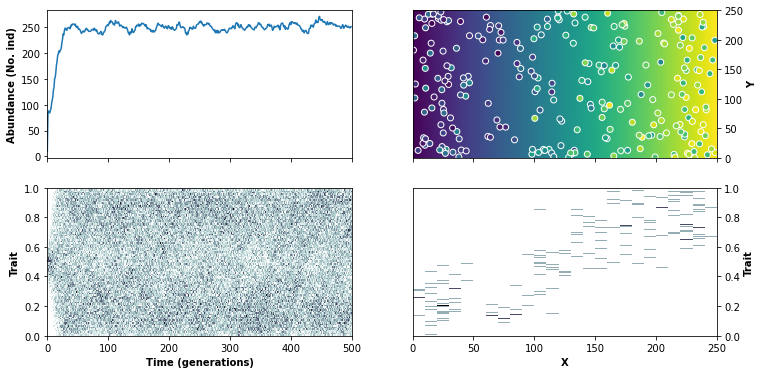

In [7]:
plot_sol(ind_dtf1, elevation1, X1)

In [8]:
taxon_lineage1 = ind_dtf1.ptree.extract_taxon_summary()
taxon_lineage1

time taxon_id ancestor_id   trait_0  abundance node_type
0        0.0        1           0  0.500000         10      root
1        1.0        2           1  0.497056         81      node
2        2.0        3           2  0.497222         88      node
3        3.0        4           3  0.494453         86      node
4        4.0        5           4  0.504764         84      node
...      ...      ...         ...       ...        ...       ...
19653  499.0    19654       19590  0.107238          5      leaf
19654  499.0    19655       19591  0.428641         12      leaf
19655  499.0    19656       19592  0.752958          9      leaf
19656  499.0    19657       19593  0.821927          5      leaf
19657  499.0    19658       19594  0.462000          5      leaf

[19658 rows x 6 columns]

In [9]:
tree1 = ind_dtf1.ptree.to_dendropy_tree()

In [10]:
tree1.print_plot()

                                               ++++++++++++++++++++++++++ 19595
                                        /+++++++                               
                                        |      |   ++++++++++++++++++++++ 19596
   ++++++++++++++++++++++++++++++++++++++      +++++                           
   |                                    |          ++++++++++++++++++++++ 19597
  ++                                    |                                      
  ||                                    \++++++++++++++++++++++++++++++++ 19598
 ++|                                                                           
 ||\------------------------------------------------------------------+++ 249  
 ||                                                                            
 |\--------------------------------------------++++++++++++++++++++++++++ 4195 
 |                                                                             
 |                          ++++++++++++

In [11]:
toytree_plot(tree1, ind_dtf1)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb581996dae0c45fe8b5a23d0a0f1dccc"> <path d="M 90.6 254.6 L

## Tree summary statistics 

Phylogenetic diversity (PD)

In [12]:
sum(tree1.calc_node_root_distances())

47920.0

In [13]:
pdm1=tree1.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [14]:
pdm1.mean_pairwise_distance()

749.019516263553

Mean neighbor taxon distance (MNTD)

In [15]:
pdm1.mean_nearest_taxon_distance()

227.79090909090908

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

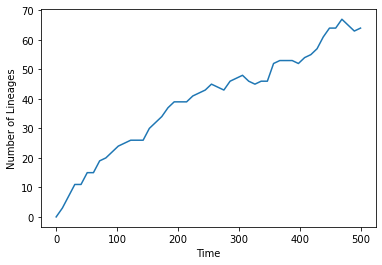

In [16]:
time_steps1 = np.linspace(0, tree1.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps1]
plt.plot(time_steps1, ltt1)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')

## Phylogeny for the speciation model with trait-mediated competition

In [17]:
ind_dtf2, elevation2, X2 = run_model(trait_comp=True)

/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [18]:
ind_dtf2

step   time   dt           x           y  taxon_id  ancestor_id  \
0          0    0.0  0.0  244.174942  110.251531       1.0          0.0   
1          0    0.0  0.0   95.048934  152.467702       1.0          0.0   
2          0    0.0  0.0  230.811558  215.905324       1.0          0.0   
3          0    0.0  0.0   65.423106  215.939418       1.0          0.0   
4          0    0.0  0.0   79.774265  168.720328       1.0          0.0   
...      ...    ...  ...         ...         ...       ...          ...   
115552   499  499.0  1.0  118.023325  192.605449   17977.0      17933.0   
115553   499  499.0  1.0  125.315676  226.577665   17977.0      17933.0   
115554   499  499.0  1.0   81.293863  215.488773   17977.0      17933.0   
115555   499  499.0  1.0   32.307754   44.717570   17977.0      17933.0   
115556   499  499.0  1.0   54.459685   48.398073   17977.0      17933.0   

        n_offspring events_i   death_i   trait_0  
0                 2        B  0.069492  0.500000  
1                 1        M  0.063454  0.500000  
2                 1        M  0.059319  0.500000  
3                 1        M  0.068145  0.500000  
4                 2        B  0.067284  0.500000  
...             ...      ...       ...       ...  
115552            0        D  1.364112  0.480150  
115553            2        B  1.305917  0.447743  
115554            1        M  1.516812  0.655870  
115555            2        B  1.362665  0.405948  
115556            2        B  1.268011  0.214289  

[115557 rows x 11 columns]

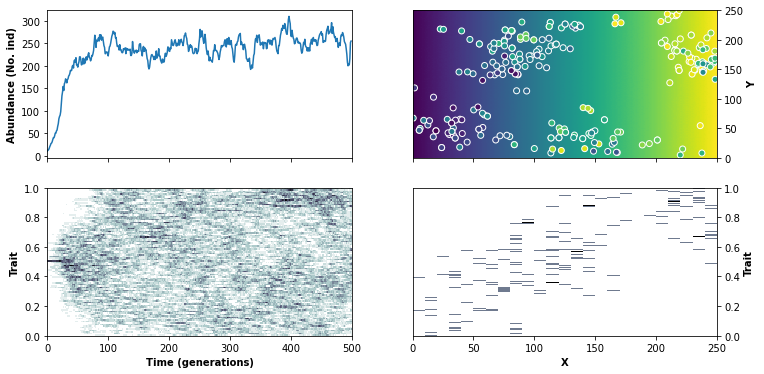

In [19]:
plot_sol(ind_dtf2, elevation2, X2)

In [20]:
taxon_lineage2 = ind_dtf2.ptree.extract_taxon_summary()
taxon_lineage2

time taxon_id ancestor_id   trait_0  abundance node_type
0        0.0        1           0  0.500000         10      root
1        1.0        2           1  0.510839         13      node
2        2.0        3           2  0.510839         13      node
3        3.0        4           3  0.514853         16      node
4        4.0        5           4  0.510981         20      node
...      ...      ...         ...       ...        ...       ...
18017  499.0    18018       17971  0.675579          8      leaf
18018  499.0    18019       17972  0.589533          5      leaf
18019  499.0    18020       17973  0.562053          9      leaf
18020  499.0    18021       17974  0.530620         10      leaf
18021  499.0    18022       17975  0.723720          4      leaf

[18022 rows x 6 columns]

In [21]:
tree2 = ind_dtf2.ptree.to_dendropy_tree()

In [22]:
tree2.print_plot()

       /---------------------------------------------------------------++ 154  
       |                                                                       
       |                                             /--------------+++++ 763  
       |                                             |                         
       |                                             |        /--------++ 1739 
       |                                             |       ++                
       |                                             |       ||  /+++++++ 4414 
       |                                            /+  ++++++++++             
       |                                            ||  |    |   \-++++++ 4042 
       |                                            ||  +    |                 
       |                                            ||  |    \-------++++ 2234 
       |                                            || ++                      
       |                                

In [23]:
toytree_plot(tree2, ind_dtf2)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t0cae463e3b564a81938d0d5c965c4caf"> <path d="M 93.6 195.3 L 93.6 195.3 L 93.9 195.3" id

## Tree summary statistics 

Phylogenetic diversity (PD)

In [24]:
sum(tree2.calc_node_root_distances())

126567.0

In [25]:
pdm2=tree2.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [26]:
pdm2.mean_pairwise_distance()

466.8987298738033

Mean neighbor taxon distance (MNTD)

In [27]:
pdm2.mean_nearest_taxon_distance()

56.205729166666664

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

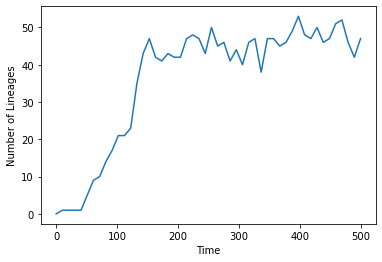

In [28]:
time_steps2 = np.linspace(0, tree2.max_distance_from_root(), 50)
ltt2 = [tree2.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps2, ltt2)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')